In [1]:
import json
from os.path import abspath
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.window import Window as W
from pyspark.sql.types import MapType,StringType,ArrayType


from datetime import datetime
from datetime import timedelta

today=datetime.now().strftime("%Y-%m-%d")
yesterday=(datetime.now()-timedelta(1)).strftime("%Y-%m-%d")

print(today,yesterday,"starting tasks at:",datetime.now())

pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:.2f}'.format

warehouse_location_path = '/home/jovyan/work/spark-warehouse'

warehouse_location = abspath(warehouse_location_path)

print(warehouse_location)

spark = SparkSession \
    .builder \
    .appName("shopee-category-search-extract") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.debug.maxToStringFields",200) \
    .config("spark.sql.debug.maxToStringFields",2000) \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.extraJavaOptions","-Dio.netty.tryReflectionSetAccessible=true -Xms4096m") \
    .config("spark.driver.extraJavaOptions","-Dio.netty.tryReflectionSetAccessible=true -Xms4096m") \
    .enableHiveSupport() \
    .getOrCreate()

spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")


2022-11-07 2022-11-06 starting tasks at: 2022-11-07 03:24:00.266392
/home/jovyan/work/spark-warehouse


In [2]:
import prestodb

cols=['product_no','day_has_session','last_day_has_session','total_impressions','daily_impression','clicks','users','cost',\
      'gmv','total_web_purchase','add_cart','avg_user_gmv','last_7d_cost','last_7d_gmv','image_link','product_type','is_zero_suppliyers']

def get_presto_data(sql):
    conn=prestodb.dbapi.connect(
        host='ec2-54-218-99-163.us-west-2.compute.amazonaws.com',
        port=8889,
        user='root',
        catalog='hive',
        schema='marketing',
    )
    cur = conn.cursor()
    cur.execute(sql)
    rows = cur.fetchall()

    conn.close()
    return rows

In [3]:
def get_last_x_day_str(x):
    return (datetime.now() - timedelta(x)).strftime('%Y-%m-%d')

last_60d = get_last_x_day_str(60)
last_7d = get_last_x_day_str(7)
last_2d = get_last_x_day_str(2)
last_1d = get_last_x_day_str(1)


def get_data(start_date = None, end_date = None):
    if start_date is None or len(start_date)<=0:
        start_date = last_60d
    if end_date is None or len(end_date)<=0:
        end_date = last_1d
    sql="""
    select a.*
        ,b.image_link
        ,b.product_type
        ,c.is_zero_suppliyers
    from
    (select 
        product_no,
        count(distinct dt) as day_has_session,
        max(dt) as last_day_has_session,
        sum(cast(impression as int)) as impression,
        sum(cast(impression as int))/count(distinct dt) as daily_impression,
        sum(cast(click_pv as int)) as clicks,
        sum(cast(users as int)) as users,
        sum(cast(cost as double)) as cost,
        sum(cast(web_gmv as double)) as gmv,
        sum(cast(web_purchase as int)) as total_web_purchase,
        sum(cast(add_cart_pv as int)) as add_cart,
        --round(1.000*sum(cast(gmv as double))/sum(cast(users as int)),3)
        0.0 as avg_user_gmv,
        round(sum(case when dt >= '{last_7d}' then cast(cost as double) else 0.0 end),2)last_7d_cost,
        round(sum(case when dt >= '{last_7d}' then cast(gmv as double) else 0.0 end),2)last_7d_gmv
    from marketing.ad_report_analysis_base a
    where dt >= '{start_date}'
        and dt <= '{end_date}'
        and dt >= '2022-09-18' -- 9月18恢复投放
        and lower(ad_channel) = 'google'
        and lower(campaign_name) not like '%_shopify_%'
        and lower(campaign_name) not like '%_deshopify_%'
        and lower(campaign_name) not like '%独立站%'
        and cast(cost as double) > 0
        and cast(impression as int) > 0
    group by 1)a
    left join(
        select id,image_link,product_type
        from marketing.facebook_catalog_app_main
        where dt = '{last_2d}'
    )b on a.product_no = b.id
    left join(
        select pno,
            case when write_uid = 8 then 'zero-suppliyers' else 'other-source' end as is_zero_suppliyers,
            count(1) cnt
        from jiayundw_dm.product_profile_df
        where date_id = '{last_2d}'
        group by 1,2
    )c on a.product_no = c.pno
    where impression>=100
    """.format(start_date=start_date, end_date=end_date,last_7d=last_7d,last_1d=last_1d,last_2d=last_2d)


    rows = get_presto_data(sql)
    print("how many data:", len(rows),"\n sample line:", rows[0])

    rdd = spark.sparkContext.parallelize(rows)
    df=rdd.toDF(cols)

    df=df.withColumn("date_written", F.lit(datetime.now().strftime('%Y-%m-%d')))
    return df

df=get_data(last_60d,last_1d)
df.printSchema()
df.write.format("parquet").mode("overwrite").partitionBy("date_written").save(warehouse_location_path + "/google-data/")

how many data: 12969 
 sample line: ['MTT022810022N', 7, '2022-10-29', 8304, 1186, 10, 4, 4.499734, 0.0, 0, 0, '0.0', 0.0, 0.0, 'https://multimedia-image.s3.us-west-2.amazonaws.com/product-center-main/2022/04/29/bbe61ff9-ec65-48fd-9f99-5ba03794ca6c.jpg?s_w=800&s_h=800', "Men's Clothing > T-shirts", 'other-source']
root
 |-- product_no: string (nullable = true)
 |-- day_has_session: long (nullable = true)
 |-- last_day_has_session: string (nullable = true)
 |-- total_impressions: long (nullable = true)
 |-- daily_impression: long (nullable = true)
 |-- clicks: long (nullable = true)
 |-- users: long (nullable = true)
 |-- cost: double (nullable = true)
 |-- gmv: double (nullable = true)
 |-- total_web_purchase: long (nullable = true)
 |-- add_cart: long (nullable = true)
 |-- avg_user_gmv: string (nullable = true)
 |-- last_7d_cost: double (nullable = true)
 |-- last_7d_gmv: double (nullable = true)
 |-- image_link: string (nullable = true)
 |-- product_type: string (nullable = true)
 |

In [4]:
model_expr="""
CASE WHEN clicks >= 150 AND total_web_purchase <= 0 THEN 'poor-no-trans'
WHEN clicks_per_purchase >= 150 AND total_web_purchase >2 AND daily_clicks >= 30 THEN 'poor-with-trans:top'
WHEN clicks_per_purchase >= 150 AND total_web_purchase >2 AND daily_clicks >= 10 THEN 'poor-with-trans:middle'
WHEN clicks_per_purchase >= 150 AND total_web_purchase >2 THEN 'poor-with-trans:tail'
WHEN clicks >= 70 
    AND (add_cart <=0 or clicks/add_cart >= 35)
    AND total_web_purchase <= 0 THEN 'poor-low-site-usage'
WHEN total_web_purchase > 0 AND daily_clicks >= 30 THEN 'normal-with-trans:top'
WHEN total_web_purchase > 0 THEN 'normal-with-trans:middle-tail'
ELSE 'normal-no-trans-yet' END
"""

In [5]:
def apply_model(df):
    df=df.withColumn("roi", F.expr("gmv/cost"))\
    .withColumn('imp_per_purchase',F.expr('case when total_web_purchase>0 then total_impressions/total_web_purchase else 0 end'))\
    .withColumn("last_7d_roi",F.expr("last_7d_gmv/last_7d_cost"))\
    .withColumn("clicks_per_purchase",F.col("clicks")/F.col('total_web_purchase'))\
    .withColumn("daily_clicks",F.col('clicks')/F.col('day_has_session'))\
    .withColumn('is_poor',F.expr(model_expr))

    # df.printSchema()
    return df
    
df = apply_model(df)

## 用9-18以来的数据进行预测和仿真

In [6]:
# df_train=apply_model(get_data('2022-09-18','2022-10-18'))
# df_train.printSchema()
# df_test=apply_model(get_data('2022-09-18'))
# df_test.printSchema()


# df_test.createOrReplaceTempView("v_google_test")
# df_train.createOrReplaceTempView("v_google_train")

# final_df=spark.sql("""
# select a.*,
#     case when b.is_poor like 'poor%' and a.is_poor like 'poor%' then 'both-poor'
#     when b.is_poor like 'poor%' and a.is_poor is not null and a.is_poor not like 'poor%' then 'poor-before-normal-now'
#     when a.is_poor like 'poor%' and b.is_poor is not null and b.is_poor not like 'poor%' then 'normal-before-poor-now'
#     when b.is_poor is null then 'new-product' else 'both-normal' end is_poor_before
# from v_google_test a
# left join v_google_train b on a.product_no=b.product_no
# """)

# final_df.groupBy("is_poor_before")\
# .agg(F.countDistinct("product_no").alias("producrs"),\
#      F.round(F.sum("cost"),2).alias("costs"),\
#      F.round(F.sum("gmv"),2).alias("gmv"),\
#      F.round(F.sum("last_7d_cost"),2).alias("last_7d_costs"),\
#      F.round(F.sum("last_7d_gmv"),2).alias("last_7d_gmv"),\
#      F.round(F.sum("cost")/F.max("day_has_session"),2).alias("avg_daily_cost"),\
#      F.round(F.sum("gmv")/F.sum("cost"),3).alias("roi"),\
#      F.round(F.sum("last_7d_gmv")/F.sum("last_7d_cost"),3).alias("last_7d_roi"))\
# .withColumn("cost_%",F.round(100.00*F.col("costs")/F.sum('costs').over(W.partitionBy(F.lit('1'))),2))\
# .withColumn("last_7d_cost_%",F.round(100.00*F.col("last_7d_costs")/F.sum('last_7d_costs').over(W.partitionBy(F.lit('1'))),2))\
# .withColumn("gmv_%",F.round(100.00*F.col("gmv")/F.sum('gmv').over(W.partitionBy(F.lit('1'))),2))\
# .show(truncate=False)

## 统计一下一共有多少商品被打标为“poor-performence”

In [7]:
df = apply_model(df)
df.groupBy(F.expr("is_poor as is_poor_performence")).agg(F.countDistinct("product_no").alias("producrs"),\
     F.round(F.sum("cost"),2).alias("costs"),\
     F.round(F.sum("gmv"),2).alias("gmv"),\
     F.round(F.sum("last_7d_cost"),2).alias("last_7d_costs"),\
     F.round(F.sum("last_7d_gmv"),2).alias("last_7d_gmv"),\
     F.round(F.sum("cost")/F.max("day_has_session"),2).alias("avg_daily_cost"),\
     F.round(F.sum("gmv")/F.sum("cost"),3).alias("roi"),\
     F.round(F.sum("last_7d_gmv")/F.sum("last_7d_cost"),3).alias("last_7d_roi"))\
.withColumn("cost_%",F.round(100.00*F.col("costs")/F.sum('costs').over(W.partitionBy(F.lit('1'))),2))\
.withColumn("last_7d_cost_%",F.round(100.00*F.col("last_7d_costs")/F.sum('last_7d_costs').over(W.partitionBy(F.lit('1'))),2))\
.withColumn("gmv_%",F.round(100.00*F.col("gmv")/F.sum('gmv').over(W.partitionBy(F.lit('1'))),2))\
.orderBy(F.desc(F.col("is_poor")),F.desc(F.col("costs")))\
.show(truncate=False)

+-----------------------------+--------+--------+---------+-------------+-----------+--------------+-----+-----------+------+--------------+-----+
|is_poor_performence          |producrs|costs   |gmv      |last_7d_costs|last_7d_gmv|avg_daily_cost|roi  |last_7d_roi|cost_%|last_7d_cost_%|gmv_%|
+-----------------------------+--------+--------+---------+-------------+-----------+--------------+-----+-----------+------+--------------+-----+
|poor-with-trans:top          |13      |6349.42 |6339.05  |503.2        |775.33     |132.28        |0.998|1.541      |4.43  |5.9           |3.63 |
|poor-with-trans:middle       |14      |2482.86 |3118.77  |244.2        |352.96     |51.73         |1.256|1.445      |1.73  |2.87          |1.79 |
|poor-no-trans                |196     |14124.98|0.0      |283.66       |0.0        |328.49        |0.0  |0.0        |9.86  |3.33          |0.0  |
|poor-low-site-usage          |305     |8612.81 |0.0      |357.97       |0.0        |215.32        |0.0  |0.0        |

## 需要多少个click才有一个purchase

0.05    10.47
0.50    40.83
0.85    97.17
0.95   159.26
0.96   165.64
0.97   172.95
0.98   180.94
Name: clicks_per_purchase, dtype: float64

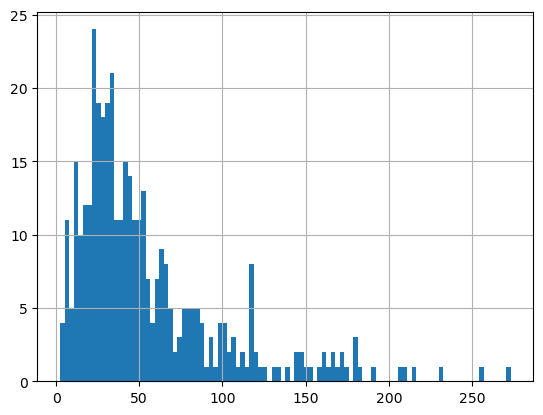

In [8]:
pd_df=df.toPandas()

has_pd = pd_df[pd_df['total_web_purchase']>2]
has_pd = has_pd[has_pd['clicks_per_purchase']<350]

has_pd['clicks_per_purchase'].hist(bins = 100)
has_pd['clicks_per_purchase'].quantile([0.05,0.5,0.85,0.95,0.96,0.97,0.98])

## 需要多少个click才有add_cart

0.05    2.98
0.50    8.00
0.85   14.99
0.95   23.96
0.96   25.96
0.97   28.04
0.98   32.92
dtype: float64

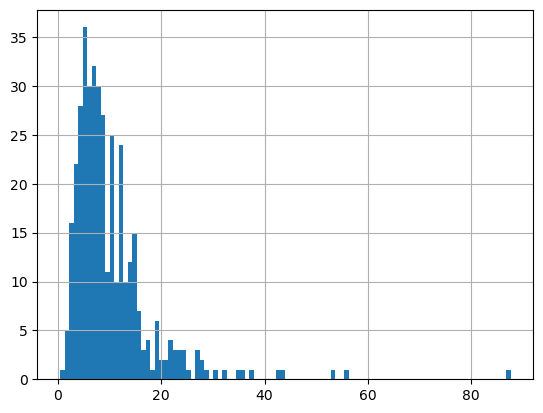

In [9]:
(has_pd['clicks']/has_pd['add_cart']).hist(bins = 100)
(has_pd['clicks']/has_pd['add_cart']).quantile([0.05,0.5,0.85,0.95,0.96,0.97,0.98])

In [10]:
(pd_df['clicks']/pd_df['day_has_session']).quantile([0.05,0.5,0.85,0.95,0.96,0.97,0.98,0.99])

0.05    1.00
0.50    1.50
0.85    2.71
0.95    5.31
0.96    6.09
0.97    7.31
0.98    9.05
0.99   13.06
dtype: float64

In [11]:
df.printSchema()

root
 |-- product_no: string (nullable = true)
 |-- day_has_session: long (nullable = true)
 |-- last_day_has_session: string (nullable = true)
 |-- total_impressions: long (nullable = true)
 |-- daily_impression: long (nullable = true)
 |-- clicks: long (nullable = true)
 |-- users: long (nullable = true)
 |-- cost: double (nullable = true)
 |-- gmv: double (nullable = true)
 |-- total_web_purchase: long (nullable = true)
 |-- add_cart: long (nullable = true)
 |-- avg_user_gmv: string (nullable = true)
 |-- last_7d_cost: double (nullable = true)
 |-- last_7d_gmv: double (nullable = true)
 |-- image_link: string (nullable = true)
 |-- product_type: string (nullable = true)
 |-- is_zero_suppliyers: string (nullable = true)
 |-- date_written: string (nullable = false)
 |-- roi: double (nullable = true)
 |-- imp_per_purchase: double (nullable = true)
 |-- last_7d_roi: double (nullable = true)
 |-- clicks_per_purchase: double (nullable = true)
 |-- daily_clicks: double (nullable = true)
 |

## 生成HTML

In [12]:
def df_to_html(all_poor_df):
    html_df=all_poor_df.selectExpr("product_no","date_marked_as_poor","round(cost,2) as all_time_cost","clicks",\
                "last_7d_cost","case when last_7d_cost/cost >=0.8 then 'new-product' else 'not-new' end as is_new","roi",\
                "replace(image_link,'.jpg','_350x350.jpg') as img_link","is_zero_suppliyers","is_poor as is_poor_performence",\
                "clicks_per_purchase","clicks/add_cart as clicks_per_add_cart","product_type")\
    .orderBy(F.desc("date_marked_as_poor"),F.desc("last_7d_cost")).toPandas()

    html_df.head(1),

    from IPython.core.display import display, HTML
    import re

    def path_to_image_html(path):
        return '<img src="'+ path + '" width="100" loading="lazy" />'

    def pno_to_link(pno):
        link = 'https://www.wholeeshopping.com/product/'+re.findall(r'\d+', pno)[0]
        return '<a href="'+ link + '" target="_blank" >' + pno + '</a>'

    def prettier_category(product_type = ""):
        return '<p class="product-type">'+product_type.replace(" > ", " > <br/>")+'</p>'

    def is_new_formatter(is_new = 'new-product'):
        color = 'red;'
        if is_new != 'new-product':
            color = 'green;'
        return '<span style="color:'+ color + '">' + is_new + '</span>'

    html = html_df.to_html(escape=False, formatters=dict(img_link = path_to_image_html, \
                                                         product_no = pno_to_link, \
                                                         is_new = is_new_formatter, \
                                                         product_type = prettier_category))

    return html

In [13]:
from pathlib import Path
home = str(Path.home())

def table_html_to_formatted_doc(html, date = last_1d):
    title = 'Google Poor Performence Products - {date}'.format(date = date)
    html = """
    <!DOCTYPE html>
<html lang="en-US">
  <head>
    <title>""" + title + """</title>
    <style>
    table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
    }
    th, td {
    padding: 2px 10px;
    text-align: left;
    }
    </style>
  </head>
  <body><h1>"""+title+"</h1>"+html+"</body></html>"
    
    file = home + '/work/html/google-poor-performence-{date}.html'.format(date=date)
    print(file)

    f = open(file, "w")
    f.write(html)
    f.close()
    
    return file

## 发送至企业微信

In [14]:
# https://developer.work.weixin.qq.com/document/path/91770#%E6%96%87%E4%BB%B6%E4%B8%8A%E4%BC%A0%E6%8E%A5%E5%8F%A3
# {
#    "errcode": 0,
#    "errmsg": "ok",
#    "type": "file",
#    "media_id": "1G6nrLmr5EC3MMb_-zK1dDdzmd0p7cNliYu9V5w7o8K0",
#    "created_at": "1380000000"
# }

import os
import requests

def send_file_msg(media_id, key = 'e5055872-a9ab-4d2f-afb0-09b6da2d1304'):
    json_data={"msgtype": "file","file": {"media_id": media_id}}
    url = 'https://qyapi.weixin.qq.com/cgi-bin/webhook/send?key={key}'.format(key=key)
    r = requests.post(url, json = json_data, headers = {'Content-Type': 'application/json'})
    print(r.text)
    return r.text

def send_text_msg(text, key = 'e5055872-a9ab-4d2f-afb0-09b6da2d1304'):
    json_data={"msgtype": "text","text": {"content": text,"mentioned_list":["wangqing","@all"]}}
    url = 'https://qyapi.weixin.qq.com/cgi-bin/webhook/send?key={key}'.format(key=key)
    r = requests.post(url, json = json_data, headers = {'Content-Type': 'application/json'})
    print(r.text)
    return r.text

def upload_file(file, file_name = None, key = 'e5055872-a9ab-4d2f-afb0-09b6da2d1304'):
    f = open(file,'rb')
    file_size = os.path.getsize(file)
    if file_name is None:
        file_name = file.split("/")[-1]
        
    url = 'https://qyapi.weixin.qq.com/cgi-bin/webhook/upload_media?key={key}&type=file'.format(key=key)
    files = {'upload_file': (file_name, f)}
    values = {'filename': 'photcat', 'filelength': 'csv', 'content-type': 'text/html'}

    r = requests.post(url, files=files, data=values)
    
    return json.loads(r.text)

In [15]:
all_poor_df = df.where("is_poor like 'poor%'").withColumn("avg_user_gmv",F.col("gmv")/F.col("users"))
print(all_poor_df.count())
all_poor_df=all_poor_df.withColumn("date_marked_as_poor", F.lit(last_1d))

all_poor_df.repartition(1).write.partitionBy("date_marked_as_poor").mode("overwrite").parquet(warehouse_location_path+'/google-daily-result')

all_unique=spark.read.parquet(warehouse_location_path+'/google-daily-result')\
.withColumn('rnk', F.row_number().over(W.partitionBy('product_no').orderBy(F.col("date_marked_as_poor"))))\
.where('rnk=1').drop('rnk').drop("date_written").orderBy(F.desc("date_marked_as_poor"),F.desc("last_7d_cost"))

print('how many products:', all_unique.count())

all_unique=all_unique.withColumn("cost", F.round('cost', 2))\
.withColumn("gmv", F.round('gmv', 2))\
.withColumn("roi", F.round('roi', 2))\
.withColumn("last_7d_roi", F.round('last_7d_roi', 2))\
.withColumn("clicks_per_purchase", F.round('clicks_per_purchase', 1))\
.withColumn("daily_clicks", F.round('daily_clicks', 1))\
.withColumn("daily_clicks", F.round('daily_clicks', 1))\
.drop("imp_per_purchase")

directory = warehouse_location_path + '/google-daily-result-csv/'
all_unique.repartition(1).write.option("header", 'true').mode("overwrite").csv(directory)
how_many_new = all_unique.where("date_marked_as_poor = '{day}'".format(day=last_1d)).count()

text = "今日新增：{how_many_new} 个效果不佳商品。".format(how_many_new=how_many_new)
csv_file_name = 'GMC效果不佳商品列表_'+ last_1d + '.csv'


for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and filename.endswith(".csv"):
        print('uploading file:',f)
        upload_result = upload_file(f, file_name=csv_file_name)
        print(upload_result)
        send_text_msg(text)
        send_file_msg(upload_result['media_id'])
        
upload_result = upload_file(table_html_to_formatted_doc(df_to_html(all_unique)))
print(upload_result)
send_file_msg(upload_result['media_id'])

528
how many products: 547
uploading file: /home/jovyan/work/spark-warehouse/google-daily-result-csv/part-00000-0d1189fb-afdb-4611-9835-aed7369400fb-c000.csv
{'errcode': 0, 'errmsg': 'ok', 'type': 'file', 'media_id': '3C1zZOIpMU6pI7U1GTDO0sAXIpgZkdeXyroPv-R7v7cjDU8CSvCqq33l2zjGfWB3U', 'created_at': '1667791519'}
{"errcode":0,"errmsg":"ok"}
{"errcode":0,"errmsg":"ok"}


/tmp/ipykernel_380/2753990888.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/home/jovyan/work/html/google-poor-performence-2022-11-06.html
{'errcode': 0, 'errmsg': 'ok', 'type': 'file', 'media_id': '3JYqDkhswwxoDyU7qm6VodQdRZaFGNf5FlrVIHtct_kdae1r3MXOfb15dGhqy7reB', 'created_at': '1667791521'}
{"errcode":0,"errmsg":"ok"}


'{"errcode":0,"errmsg":"ok"}'

In [22]:
df.withColumn("impress_lavel", F.expr("""
case when total_impressions <=1000 then 'less-1000'
when total_impressions <=5000 then 'less-5000'
when total_impressions <=10000 then 'less-10000'
else 'over-10000' end
""")).groupBy("impress_lavel")\
.agg(F.countDistinct('product_no').alias('products'),\
     F.max("day_has_session"),\
    F.sum("total_impressions").alias("total_impressions"),\
    F.round(F.sum("last_7d_gmv"),2).alias("last_7d_gmv"),\
    F.round(F.sum("last_7d_cost"),2).alias("last_7d_cost"),\
    F.round(F.sum("last_7d_gmv")/F.sum("last_7d_cost"),2).alias("las_7d_roi"))\
.withColumn("last_7d_cost_%", F.round(100.00*F.col("last_7d_cost")/F.sum("last_7d_cost").over(W.partitionBy(F.lit(1))),2))\
.withColumn("mpressions_%", F.round(100.00*F.col("total_impressions")/F.sum("total_impressions").over(W.partitionBy(F.lit(1))),2))\
.show()

+-------------+--------+--------------------+-----------------+-----------+------------+----------+--------------+------------+
|impress_lavel|products|max(day_has_session)|total_impressions|last_7d_gmv|last_7d_cost|las_7d_roi|last_7d_cost_%|mpressions_%|
+-------------+--------+--------------------+-----------------+-----------+------------+----------+--------------+------------+
|    less-5000|    3407|                  43|          8275251|    2703.09|     1361.52|      1.99|         15.98|         8.2|
|   less-10000|    1089|                  46|          7821932|    1497.02|      810.35|      1.85|          9.51|        7.76|
|    less-1000|    6368|                  32|          2334016|    1337.89|      922.09|      1.45|         10.82|        2.31|
|   over-10000|    2105|                  48|         82430909|   12184.57|     5427.66|      2.24|         63.69|       81.73|
+-------------+--------+--------------------+-----------------+-----------+------------+----------+-----

In [17]:
df.agg(F.round(F.sum("gmv"),2).alias("gmv"),\
    F.round(F.sum("cost"),2).alias("cost"),\
    F.round(F.sum("gmv")/F.sum("cost"),2).alias("roi")).show()

+---------+---------+----+
|      gmv|     cost| roi|
+---------+---------+----+
|174430.44|143245.45|1.22|
+---------+---------+----+



In [21]:
df.groupBy("is_zero_suppliyers").agg(F.countDistinct("product_no").alias("producrs"),\
     F.round(F.sum("cost"),2).alias("costs"),\
     F.round(F.sum("gmv"),2).alias("gmv"),\
     F.round(F.sum("last_7d_cost"),2).alias("last_7d_costs"),\
     F.round(F.sum("last_7d_gmv"),2).alias("last_7d_gmv"),\
     F.round(F.sum("cost")/F.max("day_has_session"),2).alias("avg_daily_cost"),\
     F.round(F.sum("gmv")/F.sum("cost"),3).alias("roi"),\
     F.round(F.sum("last_7d_gmv")/F.sum("last_7d_cost"),3).alias("last_7d_roi"))\
.withColumn("his_cost_%",F.round(100.00*F.col("costs")/F.sum('costs').over(W.partitionBy(F.lit('1'))),2))\
.withColumn("his_gmv_%",F.round(100.00*F.col("gmv")/F.sum('gmv').over(W.partitionBy(F.lit('1'))),2))\
.withColumn("7d_cost_%",F.round(100.00*F.col("last_7d_costs")/F.sum('last_7d_costs').over(W.partitionBy(F.lit('1'))),2))\
.withColumn("7d_gmv_%",F.round(100.00*F.col("last_7d_gmv")/F.sum('last_7d_gmv').over(W.partitionBy(F.lit('1'))),2))\
.orderBy(F.desc(F.col("costs")))\
.show(truncate=False)

+------------------+--------+---------+---------+-------------+-----------+--------------+-----+-----------+----------+---------+---------+--------+
|is_zero_suppliyers|producrs|costs    |gmv      |last_7d_costs|last_7d_gmv|avg_daily_cost|roi  |last_7d_roi|his_cost_%|his_gmv_%|7d_cost_%|7d_gmv_%|
+------------------+--------+---------+---------+-------------+-----------+--------------+-----+-----------+----------+---------+---------+--------+
|other-source      |12889   |142688.17|173013.15|8339.3       |16956.2    |2972.67       |1.213|2.033      |99.61     |99.19    |97.86    |95.68   |
|zero-suppliyers   |80      |557.28   |1417.29  |182.32       |766.37     |18.58         |2.543|4.203      |0.39      |0.81     |2.14     |4.32    |
+------------------+--------+---------+---------+-------------+-----------+--------------+-----+-----------+----------+---------+---------+--------+

